In [46]:
#!pip install audio-dspy librosa

In [49]:
import pandas as pd
import numpy as np
import librosa

import audio_dspy as adsp
from scipy.interpolate import interp2d
import scipy.stats as stats
from IPython.display import Audio

import os

from datasets.dataset import Dataset
from datasets import livingroom
from datasets.roomsetup import RoomSetup
import matplotlib.pyplot as plt

from utils import download_dataset_if_needed

In [2]:
download_dataset_if_needed()

path: ./LivingRoom_preprocessed_hack already exist, ignorign dataset downloading


In [43]:
def get_dataset(centroid_filename, deconvolved_filename, dataset_path):
    centroid, RIRs = None, None
    if centroid_filename is not None:
        centroid = np.load(os.path.join(dataset_path, centroid_filename))
        print("Shape of Centroid:")
        print(centroid.shape)

    if deconvolved_filename is not None:
        #Loading Room Impulse Response (1000 human locations x 10 microphones x M time samples)
        RIRs = np.load(os.path.join(dataset_path, deconvolved_filename), mmap_mode='r')
        print("Shape of RIRs:")
        print(RIRs.shape)

    dr = Dataset(RoomSetup(livingroom.speaker_xyz,
                    livingroom.mic_xyzs,
                    livingroom.x_min,
                    livingroom.x_max,
                    livingroom.y_min,
                    livingroom.y_max,
                    livingroom.walls), DATASET_PATH)
    return dr, centroid, RIRs

In [44]:
DATASET_PATH = "LivingRoom_preprocessed_hack"
empty_dataset = get_dataset(None, "deconvolved.npy", os.path.join(DATASET_PATH, "Empty"))
human1_dataset = get_dataset("centroid.npy", "deconvoled_trim.npy", os.path.join(DATASET_PATH, "Human1"))

Shape of RIRs:
(100, 10, 667200)
Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)


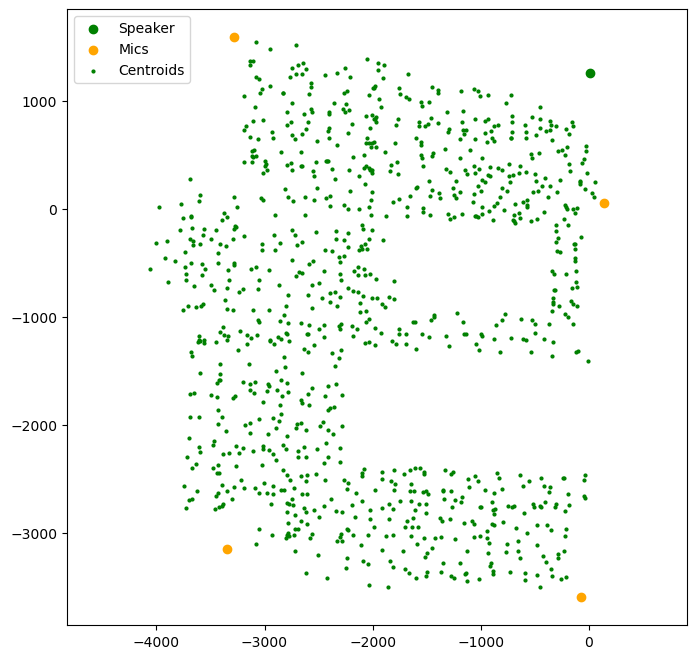

In [45]:
dr.room_setup.plot_room(human1_dataset[1])

In [27]:
def find_freqs(x, fs, thresh=30, above=0, frac_off=0.1, plot=False):
    """
    Find the mode frequencies of a signal
    Parameters
    ----------
    x : ndarray
        signal to analyze
    fs : float
        sample rate of the signal
    thresh : float, optional
        threshold to use for finding modes [dB]
    above : float, optional
        lower limit frequency to look for modes
    frac_off : float, optional
        to avoid finding multiple peaks for the same mode,
        this parameter defines a fractional offset for
        frequency breaks between modes
    plot : bool, optional
        should plot this analysis
    Returns
    -------
    freqs : ndarray
        Mode frequencies [Hz]
    peaks : ndarray
        Mode magnitudes [gain]
    """
    X = np.fft.rfft(x)
    f = np.linspace(0, fs/2, num=len(X))

    X_freqs = []
    X_peaks = []
    Mag = 20 * np.log10(np.abs(X))
    for k in range(len(X)):
        # check if above thresh
        if (Mag[k] < thresh):
            continue

        # check if within frac_off of a larger peak
        k_test = k
        flag = 0
        while (k_test < (len(X) - 1)) and (f[k_test] < f[k] * (1 + frac_off)):
            k_test += 1
            if Mag[k_test] > Mag[k]:
                flag = 1
                break

        k_test = k
        while(f[k_test] > f[k] * (1 - frac_off)):
            k_test -= 1
            if Mag[k_test] > Mag[k]:
                flag = 1
                break

        if flag == 1:
            continue

        # if above lower limit
        if (f[k] > above):
            X_freqs.append(f[k])
            X_peaks.append(np.abs(X[k]))

    # plot if needed
    if plot:
        plt.semilogx(f, 20 * np.log10(np.abs(X)))
        for freq in X_freqs:
            plt.axvline(freq, color='r')
        plt.ylabel('Magnitude [dB]')
        plt.xlabel('Frequency [Hz]')
        plt.xlim(20,22050)

    return np.asarray(X_freqs), np.asarray(X_peaks)

In [7]:
def get_dampings(x, fs, thresh=30, above=0, frac_off=0.1, plot=False):
    freqs = find_freqs(x, fs, above=above, thresh=thresh, frac_off=frac_off, plot=False)[0]
    
    filt_width=20
    thresh=-40
    eta=0.01
    taus = []
    tau_freqs = []
    for freq in freqs:
        x_filt = adsp.filt_mode(x, freq, fs, filt_width)
        env = adsp.normalize(adsp.energy_envelope(x_filt, fs, eta))

        top = int(np.argmax(20 * np.log10(env)))
        noise_floor = np.max(20 * np.log10(env[int(len(env)*0.9):]))
        top_val = 20 * np.log10(env[top])
        start = int(np.argwhere(20 * np.log10(env[top:]) < (noise_floor + (top_val-noise_floor) * 0.9))[0]) + top
        end = int(np.argwhere(20 * np.log10(env[start:]) < (noise_floor + (top_val-noise_floor) * 0.1))[0]) + start
        if end <= start:
            continue
        slope, _, _, _, _ = stats.linregress(
            np.arange(len(env[start:end])), 20 * np.log10(env[start:end]))

        gamma = 10**(slope/20)
        tau = -1 / np.log(gamma)
        taus.append(tau)
        tau_freqs.append(freq)
        
        if plot:
            plt.figure()
            plt.title('Decay model for mode = {0:.2f} Hz'.format(freq))
            n = np.arange(len(env))
            plt.plot(n / fs, 20*np.log10(np.abs(x_filt)))
            plt.plot(n / fs, 20*np.log10(env))
            plt.plot(n / fs, 20*np.log10(np.exp(-1.0 * n / tau)), color='r')
            plt.xlabel('Time [s]')
            plt.ylim(thresh * 2, 5)

    return 1./np.array(taus), np.array(tau_freqs)

In [29]:
data = RIRs[0, 0]
sampling_rate = 48e3

#freqs = find_freqs(data, sampling_rate, above=20, thresh=5, frac_off=0.1, plot=True)[0]
#plt.show()
#dampings, damp_freqs = get_dampings(data, sampling_rate, above=20, thresh=5, frac_off=0.1, plot=True)
#plt.show()
data.shape[0]

667200

In [30]:
import librosa

In [53]:
def get_audio_from(dt, human: int, micro: int):
    return Audio(dt[2][human,micro], rate=sampling_rate)

In [54]:
get_audio_from(human1_dataset, 0, 0)

In [60]:
def show_spec(S):
    plt.figure()
    librosa.display.specshow(S)
    plt.colorbar()
    
def plot_spectro(dt, human: int, micro: int):
    data = dt[2][human, micro]
    D = librosa.stft(data)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    show_spec(S_db)
    return S_db

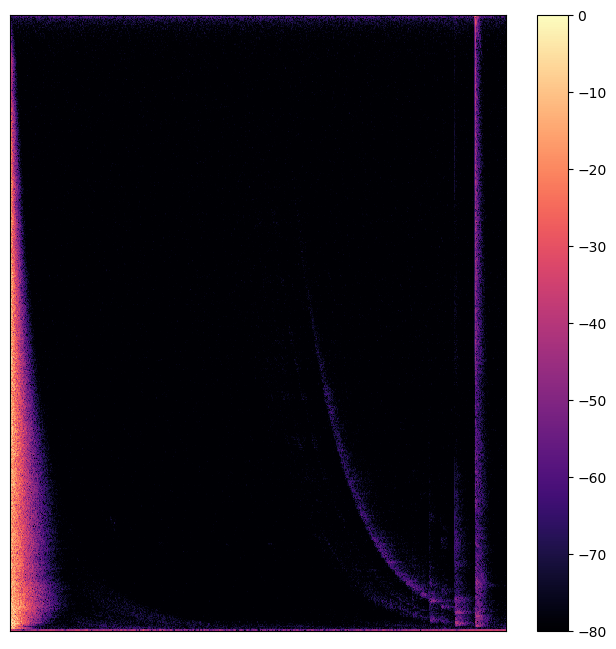

In [57]:
S_human = plot_spectro(human1_dataset, 0, 0)

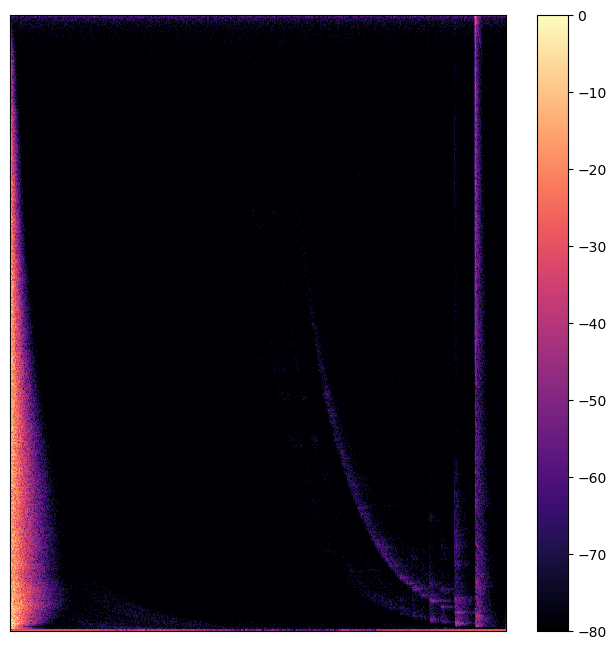

In [58]:
S_empty = plot_spectro(empty_dataset, 0, 0)

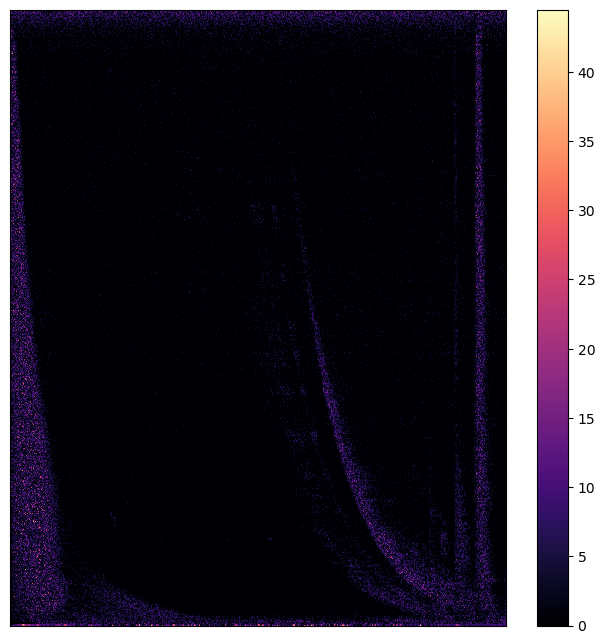

In [62]:
show_spec(np.abs(S_empty - S_human))

In [63]:
np.abs(S_empty - S_human).shape

(1025, 1304)